In [1]:
import pandas as pd
import numpy as np

In [4]:
GC_df_08 = pd.read_csv(r"../util/data/FY2008/structured/original/GuilfordCountyOriginalDataFY08.csv")
GC_df_08.drop(['Unnamed: 0'], axis=1,inplace=True)
GC_df_08.head(5)

,page_number,word
0,3,fy
1,3,adopted
2,3,budget
3,3,june
4,3,prepared


In [5]:
import sys
# !{sys.executable} -m spacy download en
import re, numpy as np, pandas as pd
from pprint import pprint

# Gensim
import gensim, spacy, logging, warnings
import gensim.corpora as corpora
from gensim.utils import lemmatize, simple_preprocess
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt

# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_', 'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see', 'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 'right', 'line', 'even', 'also', 'may', 'take', 'come'])

%matplotlib inline
warnings.filterwarnings("ignore",category=DeprecationWarning)
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

In [6]:
def sent_to_words(sentences):
    for sent in sentences:
        sent = re.sub('\S*@\S*\s?', '', sent)  # remove emails
        sent = re.sub('\s+', ' ', sent)  # remove newline chars
        sent = re.sub("\'", "", sent)  # remove single quotes
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True) 
        yield(sent)  

# Convert to list
data = GC_df_08.word.values.tolist()
data_words = list(sent_to_words(data))
print(data_words[:1])
# [['from', 'irwin', 'arnstein', 'subject', 're', 'recommendation', 'on', 'duc', 'summary', 'whats', 'it', 'worth', 'distribution', 'usa', 'expires', 'sat', 'may', 'gmt', ...trucated...]]

[['fy']]


In [7]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# !python3 -m spacy download en  # run in terminal once
def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    nlp = spacy.load('en', disable=['parser', 'ner'])
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out

data_ready = process_words(data_words)  # processed Text Data!

In [15]:
# Create Dictionary
id2word = corpora.Dictionary(data_ready)

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_ready]

# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10, 
                                           passes=10,
                                           alpha = 'auto',
                                           eta = 'auto',
                                           random_state = 1)

pprint(lda_model.print_topics())

[(0,
  '0.217*"project" + 0.077*"employee" + 0.067*"adopt" + 0.065*"balance" + '
  '0.058*"facility" + 0.046*"increase" + 0.041*"prior" + 0.034*"department" + '
  '0.030*"information" + 0.028*"risk"'),
 (1,
  '0.225*"capital" + 0.072*"tax" + 0.048*"care" + 0.047*"maintain" + '
  '0.041*"court" + 0.039*"transportation" + 0.037*"student" + '
  '0.036*"technology" + 0.033*"level" + 0.027*"base"'),
 (2,
  '0.254*"total" + 0.100*"program" + 0.097*"expenditure" + 0.048*"area" + '
  '0.037*"space" + 0.033*"staff" + 0.030*"law" + 0.028*"economic" + '
  '0.025*"work" + 0.021*"administration"'),
 (3,
  '0.177*"fund" + 0.168*"bond" + 0.109*"system" + 0.062*"point" + 0.056*"cost" '
  '+ 0.025*"ordinance" + 0.024*"incentive" + 0.022*"require" + 0.022*"rate" + '
  '0.021*"result"'),
 (4,
  '0.338*"approve" + 0.105*"budget" + 0.057*"development" + 0.051*"time" + '
  '0.046*"construction" + 0.037*"fire" + 0.037*"building" + 0.032*"citizen" + '
  '0.030*"position" + 0.025*"training"'),
 (5,
  '0.226*"y

In [16]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_ready)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,7.0,0.2056,"service, contract, water, amend, payment, desc...",[]
1,1,0.0,0.5410,"project, employee, adopt, balance, facility, i...",[adopt]
2,2,4.0,0.5368,"approve, budget, development, time, constructi...",[budget]
3,3,7.0,0.2056,"service, contract, water, amend, payment, desc...",[]
4,4,7.0,0.2056,"service, contract, water, amend, payment, desc...",[]
5,5,7.0,0.2056,"service, contract, water, amend, payment, desc...",[]
6,6,7.0,0.2056,"service, contract, water, amend, payment, desc...",[]
7,7,5.0,0.5279,"year, provide, high, funding, protection, prop...",[office]
8,8,7.0,0.2056,"service, contract, water, amend, payment, desc...",[]
9,9,4.0,0.5368,"approve, budget, development, time, constructi...",[budget]


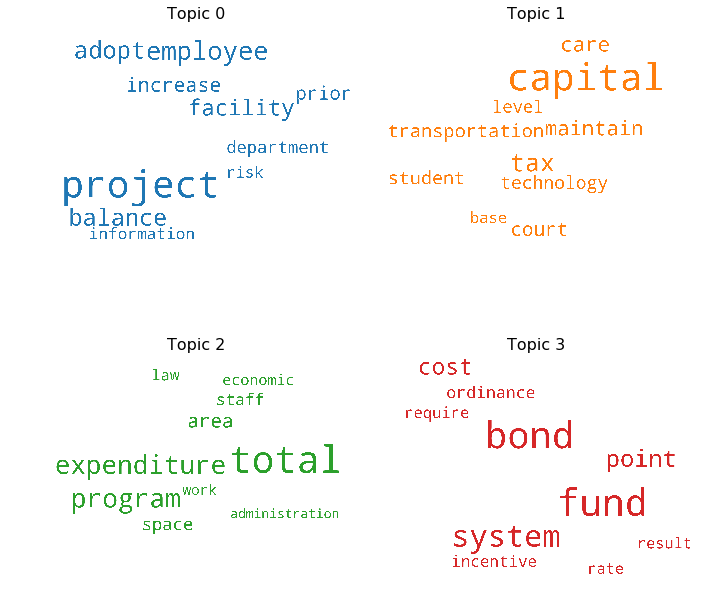

In [19]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

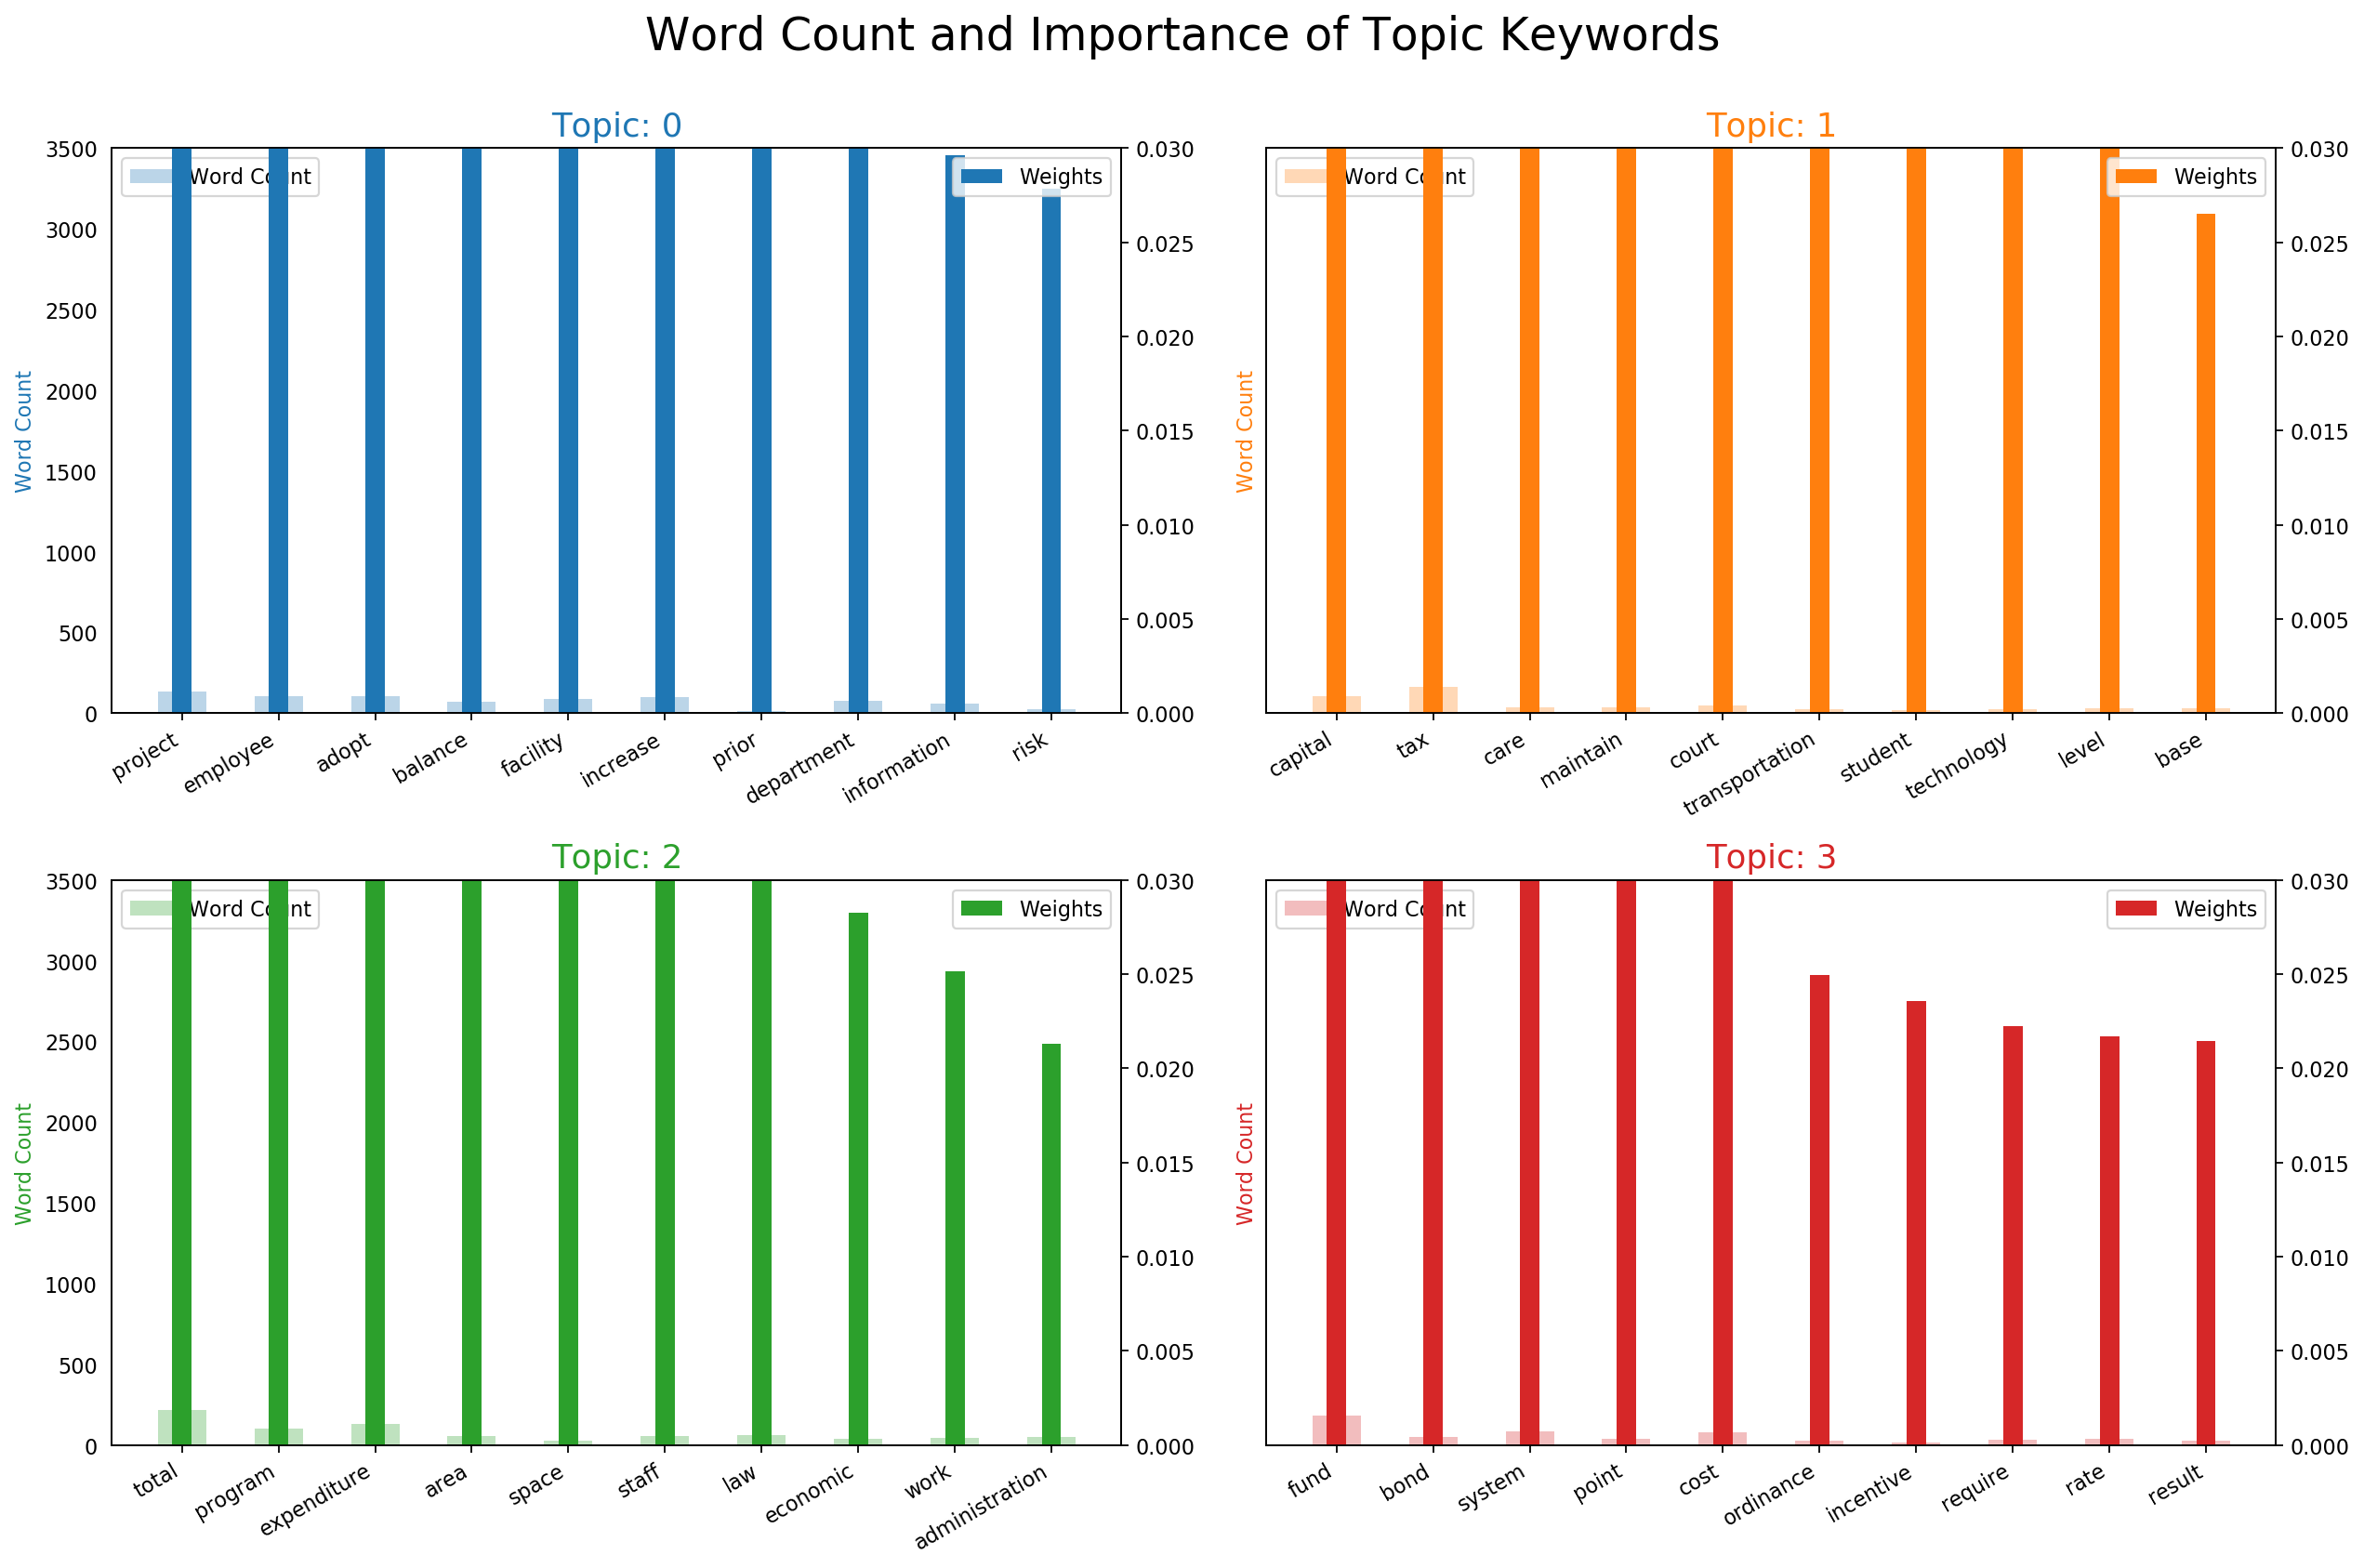

In [32]:
from collections import Counter
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in data_ready for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(2, 2, figsize=(16,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

In [37]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary=lda_model.id2word)
vis

/anaconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7      0.437185 -0.011398       1        1  24.829453
0     -0.033021  0.392509       2        1  10.524158
2     -0.043504 -0.082291       3        1  10.171333
4     -0.035239 -0.088478       4        1   9.657599
8     -0.052697 -0.042516       5        1   9.105950
5     -0.044817 -0.044792       6        1   7.669320
3     -0.055009 -0.034455       7        1   7.246873
9     -0.056125 -0.030487       8        1   7.237836
6     -0.058487 -0.029221       9        1   6.852560
1     -0.058287 -0.028872      10        1   6.704917, topic_info=     Category        Freq            Term       Total  loglift  logprob
term                                                                   
275   Default  508.000000         approve  508.000000  30.0000  30.0000
225   Default  402.000000           total  402.000000  29.0000  29.0000
96    Default  356.000000         project  356.000000  28.0000  28.0000
83    Default  278.000000          school  278.000000  27.0000  27.0000
39    Default  535.000000         service  535.000000  26.0000  26.0000
118   Default  270.000000            year  270.000000  25.0000  25.0000
80    Default  235.000000         capital  235.000000  24.0000  24.0000
20    Default  220.000000         revenue  220.000000  23.0000  23.0000
22    Default  200.000000            fund  200.000000  22.0000  22.0000
276   Default  190.000000            bond  190.000000  21.0000  21.0000
132   Default  185.000000         provide  185.000000  20.0000  20.0000
378   Default  300.000000        contract  300.000000  19.0000  19.0000
77    Default  291.000000           water  291.000000  18.0000  18.0000
92    Default  161.000000     improvement  161.000000  17.0000  17.0000
1     Default  159.000000          budget  159.000000  16.0000  16.0000
93    Default  158.000000         program  158.000000  15.0000  15.0000
122   Default  135.000000         include  135.000000  14.0000  14.0000
23    Default  155.000000     expenditure  155.000000  13.0000  13.0000
79    Default  123.000000          system  123.000000  12.0000  12.0000
70    Default  120.000000       community  120.000000  11.0000  11.0000
245   Default  122.000000         operate  122.000000  10.0000  10.0000
147   Default  119.000000            high  119.000000   9.0000   9.0000
126   Default  119.000000         funding  119.000000   8.0000   8.0000
253   Default  127.000000        employee  127.000000   7.0000   7.0000
33    Default  104.000000         support  104.000000   6.0000   6.0000
0     Default  110.000000           adopt  110.000000   5.0000   5.0000
3     Default   90.000000      management   90.000000   4.0000   4.0000
109   Default  107.000000         balance  107.000000   3.0000   3.0000
85    Default   82.000000         expense   82.000000   2.0000   2.0000
47    Default   92.000000          public   92.000000   1.0000   1.0000
...       ...         ...             ...         ...      ...      ...
324   Topic10    0.139683       challenge    1.232823   0.5246  -8.9175
224   Topic10    0.139683     formulation    1.232823   0.5246  -8.9175
308   Topic10    0.139683       classroom    1.232823   0.5246  -8.9175
185   Topic10    0.139683           today    1.232823   0.5246  -8.9175
290   Topic10    0.139683          fourth    1.232823   0.5246  -8.9175
169   Topic10    0.139683        announce    1.232823   0.5246  -8.9175
231   Topic10    0.139683        entirely    1.232823   0.5246  -8.9175
230   Topic10    0.139683          almost    1.232823   0.5246  -8.9175
190   Topic10    0.139683          vision    1.232823   0.5246  -8.9175
229   Topic10    0.139683    schoolrelate    1.232823   0.5246  -8.9175
270   Topic10    0.139683           bring    1.232823   0.5246  -8.9175
311   Topic10    0.139683          region    1.232823   0.5246  -8.9175
17    Topic10    0.139683  organizational    1.232823   0.5246  -8.91

In [40]:
dictionary=corpora.Dictionary(data_ready)

In [41]:
from gensim.models.coherencemodel import CoherenceModel
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_ready, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.8247949042506306


In [42]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model=LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

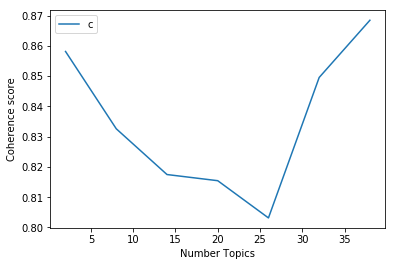

In [45]:
from gensim.models.ldamodel import LdaModel
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=corpus, texts=data_ready, start=2, limit=40, step=6)
# Graphs shows the optimal number of topics
import matplotlib.pyplot as plt
%matplotlib inline
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Number Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()